In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_evaluation/automl_tabular_regression_model_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_evaluation/automl_tabular_regression_model_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_evaluation/automl_tabular_regression_model_evaluation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook demonstrates how to use Vertex AI regression model evaluation componenet to evaluate an AutoML regression model. Model evaluation helps you determine your model performance based on the evaluation metrics and improve the model if necessary. 

### Objective

In this tutorial, you learn how to evaluate a pre-trained Vetex AI model resource  through a Vertex AI pipeline job using `google_cloud_pipeline_components`:

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI `AutoML` 
- Vertex AI `Pipeline`


The steps performed include:

- Import a pre-trained `AutoML model resource` into the pipeline
- Run a `batch prediction` job
- Evaulate the AutoML model using the `regression evluation component`

### Dataset

The dataset being used in this notebook is a part of the PetFinder Dataset, available [here](https://www.kaggle.com/c/petfinder-adoption-prediction) on Kaggle. The current dataset is only a part of the original dataset considered for the problem of predicting whether the pet is adopted or not. It consists of the following fields:

- `Type`: Type of animal (1 = Dog, 2 = Cat)
- `Age`: Age of pet when listed, in months
- `Breed1`: Primary breed of pet
- `Gender`: Gender of pet
- `Color1`: Color 1 of pet 
- `Color2`: Color 2 of pet
- `MaturitySize`: Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- `FurLength`: Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- `Vaccinated`: Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- `Sterilized`: Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- `Health`: Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- `Fee`: Adoption fee (0 = Free)
- `PhotoAmt`: Total uploaded photos for this pet
- `Adopted`: Whether or not the pet was adopted (Yes/No).

**Note**: This dataset is moved to a public Cloud Storage bucket and is accessed from there in this notebook.

### Costs 
This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Installation

Install the following packages required to execute this notebook. 



In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q
! pip3 install google-cloud-pipeline-components==1.0.17 {USER_FLAG} -q
! pip3 install --upgrade kfp google-cloud-pipeline-components {USER_FLAG} -q
! pip3 install --upgrade matplotlib {USER_FLAG} -q

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Compute Engine, and Dataflow APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,dataflow.googleapis.com). {TODO: Update the APIs needed for your tutorial. Edit the API names, and update the link to append the API IDs, separating each one with a comma. For example, container.googleapis.com,cloudbuild.googleapis.com}

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Compute service account storage object creator and viewer permissions!!!**

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: vertex-ai-dev


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update



To take a quick anonymous survey, run:
  $ gcloud survey



#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. It is recommended that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.



In [5]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you run a Vertex AI pipeline job using the Cloud SDK, your job stores the pipeline artifacts to a Cloud Storage bucket. In this tutorial, you create a Vertex AI Pipeline job that saves the artifacts like evaluation metrics and feature attributes to a Cloud Storage bucket.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.

In [6]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [7]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [8]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://vertex-ai-devaip-quar9hbz/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [9]:
! gsutil ls -al $BUCKET_URI

#### Service Account

You use a service account to create Vertex AI Pipeline jobs. If you do not want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [10]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [13]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 931647533046-compute@developer.gserviceaccount.com


#### Set service account access for {TODO; e.g., Vertex AI Pipelines}

Run the following commands to grant your service account access to {TODO; i.e., read and write pipeline artifacts} in the bucket that you created in the previous step. You only need to run this step once per service account.

In [14]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Import libraries

In [15]:
import google.cloud.aiplatform as aiplatform
import kfp
from kfp.v2 import compiler
from google.cloud import aiplatform_v1
import matplotlib.pyplot as plt
import json

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [16]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Create Vertex AI Dataset

Create a managed tabular dataset resource in Vertex AI using the dataset source.

In [17]:
DATA_SOURCE = "gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv"

In [18]:
# Create the Vertex AI Dataset resource
dataset = aiplatform.TabularDataset.create(
    display_name="petfinder-tabular-dataset",
    gcs_source=DATA_SOURCE,
)

print ("Resource name:",dataset.resource_name)

Creating TabularDataset
Create TabularDataset backing LRO: projects/931647533046/locations/us-central1/datasets/9019973380832493568/operations/3060886783697879040
TabularDataset created. Resource name: projects/931647533046/locations/us-central1/datasets/9019973380832493568
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/931647533046/locations/us-central1/datasets/9019973380832493568')
Resource name: projects/931647533046/locations/us-central1/datasets/9019973380832493568


## Train AutoML model

Train a simple regression model using the created dataset using `Age` as the target column. 

Set a display name and create the `AutoMLTabularTrainingJob` with appropriate data types specified for column transformations.

In [19]:
TRAINING_JOB_DISPLAY_NAME = "[your-train-job-display-name]" # @param {type:"string"}

In [20]:
# If no display name is specified, use the default one
if TRAINING_JOB_DISPLAY_NAME == "" or \
    TRAINING_JOB_DISPLAY_NAME is None or TRAINING_JOB_DISPLAY_NAME == "[your-train-job-display-name]":
    TRAINING_JOB_DISPLAY_NAME = "train-pet-agefinder-automl"

An AutoML training job is created with the `AutoMLForecastingTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `optimization_prediction_type`: The type of prediction the Model is to produce. Ex: regression,classification
- `column_transformations`: (Optional): Transformations to apply to the input columns
- `optimization_objective`: The optimization objective to minimize or maximize.
    - `minimize-rmse`
    - `minimize-mae`
    - `minimize-rmsle`

In [22]:
train_job = aiplatform.AutoMLTabularTrainingJob(
    display_name=TRAINING_JOB_DISPLAY_NAME,
    optimization_prediction_type="regression",
    column_transformations=[
        {"categorical": {"column_name": "Type"}},
        {"categorical": {"column_name": "Breed1"}},
        {"categorical": {"column_name": "Gender"}},
        {"categorical": {"column_name": "Color1"}},
        {"categorical": {"column_name": "Color2"}},
        {"categorical": {"column_name": "MaturitySize"}},
        {"categorical": {"column_name": "FurLength"}},
        {"categorical": {"column_name": "Vaccinated"}},
        {"categorical": {"column_name": "Sterilized"}},
        {"categorical": {"column_name": "Health"}},
        {"numeric": {"column_name": "Fee"}},
        {"numeric": {"column_name": "PhotoAmt"}},
        {"categorical": {"column_name": "Adopted"}},

    ],   
    optimization_objective="minimize-rmse"
)

print(train_job)

/usr/local/lib/python3.9/site-packages/google/cloud/aiplatform/training_jobs.py:4562: DeprecationWarning: consider using column_specs instead. column_transformations will be deprecated in the future.
  column_transformations_utils.validate_and_get_column_transformations(


Set the display name for the model.

In [23]:
MODEL_DISPLAY_NAME = "[your-model-display-name]" # @param {type:"string"}

In [24]:
# If no name is specified, use the default name
if MODEL_DISPLAY_NAME == "" or \
    MODEL_DISPLAY_NAME is None or MODEL_DISPLAY_NAME == "[your-model-display-name]":
    MODEL_DISPLAY_NAME = "pet-agefinder-prediction-model"

Next, you start the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `target_column`: The name of the column values of which the Model is to predict.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `model_display_name`: The human readable name for the trained model.
- `disable_early_stopping`: If true, the entire budget is used.
- `budget_milli_node_hours`: (optional) Maximum training time specified in unit of millihours (1000 = hour).



The training job takes roughly 1.5-2 hours to finish.

In [ ]:
# Run the training job
model = train_job.run(
    dataset=dataset,
    target_column="Age",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    model_display_name=MODEL_DISPLAY_NAME,
    disable_early_stopping=False,
    budget_milli_node_hours=1000,
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4882406946784673792?project=931647533046
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trainingPipelines/4882406946784673792 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trainingPipelines/4882406946784673792 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trainingPipelines/4882406946784673792 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trainingPipelines/4882406946784673792 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trainingPipelines/4882406946784673792 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/931647533046/locations/us-central1/trai

## List model evaluations from training

After the training job is finished, get the model evaluations and print them.

In [ ]:
# Get evaluations
model_evaluations = model.list_model_evaluations()

model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

In [ ]:
# Print the evaluation metrics
for evaluation in model_evaluations:
    evaluation = evaluation.to_dict()
    print("Model's evaluation metrics from Training:\n")
    metrics = evaluation["metrics"]
    for metric in metrics.keys():
        print(f"metric: {metric}, value: {metrics[metric]}\n")

## Create Pipeline for evaluations

Now, you run a Vertex AI BatchPrediction job and generate evaluations and feature-attributions on its results. 

To do so, you create a Vertex AI pipeline using the components available from the [`google-cloud-pipeline-components`](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/index.html) python package.



### Define the Pipeline

While defining the flow of the pipeline, you get the model resource first. Then, you sample the provided source dataset for batch predictions and create a batch prediction. The explanations are enabled while creating the batch prediction job to generate feature attributions. Once the batch prediction job is completed, you get the regression evaluation metrics and the feature attributions from the results.

The pipeline uses the following components:

- `GetVertexModelOp`: Gets a Vertex Model Artifact. For more details, please check [here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.experimental.evaluation.html#google_cloud_pipeline_components.experimental.evaluation.GetVertexModelOp).
- `EvaluationDataSamplerOp`: Randomly downsamples an input dataset to a specified size for computing Vertex XAI feature attributions for AutoML Tables and custom models. Creates a Dataflow job with Apache Beam to downsample the dataset. For more details, please check [here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.experimental.evaluation.html#google_cloud_pipeline_components.experimental.evaluation.EvaluationDataSamplerOp).
- `ModelBatchPredictOp`: Creates a Google Cloud Vertex BatchPredictionJob and waits for it to complete. For more details, please check [here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.ModelBatchPredictOp).
- `ModelEvaluationRegressionOp`: Compute evaluation metrics on a trained model’s batch prediction results. Creates a dataflow job with Apache Beam and TFMA to compute evaluation metrics. Supports regression for tabular data.[here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.experimental.evaluation.html#google_cloud_pipeline_components.experimental.evaluation.ModelEvaluationRegressionOp).
- `ModelEvaluationFeatureAttributionOp`: Compute feature attribution on a trained model’s batch explanation results. Creates a dataflow job with Apache Beam and TFMA to compute feature attributions. For more details, please check [here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.experimental.evaluation.html#google_cloud_pipeline_components.experimental.evaluation.ModelEvaluationFeatureAttributionOp).
- `ModelImportEvaluationOp`: Imports a model evaluation artifact to an existing Vertex model with ModelService.ImportModelEvaluation. For more details, please check [here](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.17/google_cloud_pipeline_components.experimental.evaluation.html#google_cloud_pipeline_components.experimental.evaluation.ModelImportEvaluationOp).

## Model Evaluation

In [ ]:
@kfp.dsl.pipeline(
    name='vertex-evaluation-automl-tabular-feature-attribution-pipeline')
def evaluation_automl_tabular_feature_attribution_pipeline(
    project: str,
    location: str,
    root_dir: str,
    prediction_type: str,
    model_name: str,
    target_column_name: str,
    batch_predict_gcs_source_uris: list,
    batch_predict_instances_format: str,
    batch_predict_predictions_format: str = 'jsonl',
    batch_predict_machine_type: str = 'n1-standard-4',
    batch_predict_starting_replica_count: int = 5,
    batch_predict_max_replica_count: int = 10,
    batch_predict_explanation_metadata: dict = {},
    batch_predict_explanation_parameters: dict = {},
    batch_predict_explanation_data_sample_size: int = 10000,
    dataflow_machine_type: str = 'n1-standard-4',
    dataflow_max_num_workers: int = 5,
    dataflow_disk_size_gb: int = 50,
    dataflow_service_account: str = '',
    dataflow_subnetwork: str = '',
    dataflow_use_public_ips: bool = True,
    encryption_spec_key_name: str = ''):
  
    from google_cloud_pipeline_components.experimental.evaluation import (
        GetVertexModelOp,
        EvaluationDataSamplerOp,
        ModelEvaluationRegressionOp, 
        ModelEvaluationFeatureAttributionOp,
        ModelImportEvaluationOp
    )
    from google_cloud_pipeline_components.aiplatform import ModelBatchPredictOp
    
    # Get the Vertex AI model resource
    get_model_task = GetVertexModelOp(model_resource_name=model_name)
    
    # Run Data-sampling task
    data_sampler_task = EvaluationDataSamplerOp(
                          project=project,
                          location=location,
                          root_dir=root_dir,
                          gcs_source_uris=batch_predict_gcs_source_uris,
                          instances_format=batch_predict_instances_format,
                          sample_size=batch_predict_explanation_data_sample_size
                        )
    
    # Run Batch Explanations
    batch_explain_task = ModelBatchPredictOp(
                            project=project,
                            location=location,
                            model=get_model_task.outputs['model'],
                            job_display_name='model-registry-batch-predict-evaluation',
                            gcs_source_uris= data_sampler_task.outputs['gcs_output_directory'],
                            instances_format=batch_predict_instances_format,
                            predictions_format=batch_predict_predictions_format,
                            gcs_destination_output_uri_prefix=root_dir,
                            machine_type=batch_predict_machine_type,
                            starting_replica_count=batch_predict_starting_replica_count,
                            max_replica_count=batch_predict_max_replica_count,
                            encryption_spec_key_name=encryption_spec_key_name,
                            # Set the explanation parameters
                            generate_explanation=True,
                            explanation_parameters=batch_predict_explanation_parameters,
                            explanation_metadata=batch_predict_explanation_metadata,
                        )

    # Run evaluation based on prediction type and feature attribution component.
    # After, import the model evaluations to the Vertex model.
    eval_task = ModelEvaluationRegressionOp(
                  project=project,
                  location=location,
                  root_dir=root_dir,
                  ground_truth_column=target_column_name,
                  predictions_gcs_source=batch_explain_task.outputs['gcs_output_directory'],
                  predictions_format=batch_predict_predictions_format,
                  dataflow_machine_type=dataflow_machine_type,
                  dataflow_max_workers_num=dataflow_max_num_workers,
                  dataflow_disk_size=dataflow_disk_size_gb,
                  dataflow_service_account=dataflow_service_account,
                  dataflow_subnetwork=dataflow_subnetwork,
                  dataflow_use_public_ips=dataflow_use_public_ips,
                  encryption_spec_key_name=encryption_spec_key_name
                )
    
    # Get Feature Attributions
    feature_attribution_task = ModelEvaluationFeatureAttributionOp(
                                  project=project,
                                  location=location,
                                  root_dir=root_dir,
                                  predictions_format='jsonl',
                                  predictions_gcs_source=batch_explain_task.outputs['gcs_output_directory'],
                                  dataflow_machine_type=dataflow_machine_type,
                                  dataflow_max_workers_num=dataflow_max_num_workers,
                                  dataflow_disk_size=dataflow_disk_size_gb,
                                  dataflow_service_account=dataflow_service_account,
                                  dataflow_subnetwork=dataflow_subnetwork,
                                  dataflow_use_public_ips=dataflow_use_public_ips,
                                  encryption_spec_key_name=encryption_spec_key_name
                                )

    ModelImportEvaluationOp(
          problem_type=prediction_type,
          regression_metrics=eval_task.outputs['evaluation_metrics'],
          feature_attributions=feature_attribution_task.outputs['feature_attributions'],
          model=get_model_task.outputs['model'],
          dataset_type=batch_predict_instances_format
    )

### Compile the pipeline

Next, compile the pipline to the `tabular_regression_pipline.json` file.

In [ ]:

compiler.Compiler().compile(
    pipeline_func=evaluation_automl_tabular_feature_attribution_pipeline,
    package_path="tabular_regression_pipeline.json",
)

### Define the parameters to run the pipeline

Specify the required parameters to run the pipeline.

Set a display name for your pipeline.

In [ ]:
PIPELINE_DISPLAY_NAME = "[your-pipeline-display-name]" # @param {type:"string"}

In [ ]:
# If no display name is set, use the default one
if PIPELINE_DISPLAY_NAME == "[your-pipeline-display-name]" or \
    PIPELINE_DISPLAY_NAME == "" or PIPELINE_DISPLAY_NAME is None:
    PIPELINE_DISPLAY_NAME = "pet_agefinder_" + UUID 

To pass the required arguments to the pipeline, you define the following paramters below:

- `project`: Project ID.
- `location`: Region where the pipeline is run.
- `root_dir`: The GCS directory for keeping staging files and artifacts. A random subdirectory will be created under the directory to keep job info for resuming the job in case of failure.
- `model_name`: Resource name of the trained AutoML Tabular Regression model.
- `prediction_type`: Type of the prediction (In this tutorial, it is "regression").
- `target_column_name`: Name of the column to be used as the target for regression.
- `batch_predict_gcs_source_uris`: List of the Cloud Storage bucket uris of input instances for batch prediction.
- `batch_predict_instances_format`: Format of the input instances for batch prediction.
- `batch_predict_explanation_data_sample_size`: Size of the samples to be considered for batch prediction and evaluation.

In [ ]:
PIPELINE_ROOT = f"{BUCKET_URI}/pipeline_root/pet_agefinder_{UUID}"
parameters = {
            'project':PROJECT_ID,
            'location':REGION,
            'root_dir':PIPELINE_ROOT,
            'model_name':model.resource_name,
            'prediction_type':"regression",
            'target_column_name':"Age",
            'batch_predict_gcs_source_uris':[DATA_SOURCE],
            'batch_predict_instances_format':'csv',
            'batch_predict_explanation_data_sample_size': 3000
        }

Run the pipeline using the configured `SERVICE_ACCOUNT`.

In [ ]:
job = aiplatform.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path="tabular_regression_pipeline.json",
    parameter_values=parameters,
    enable_caching=True,
)

job.run(service_account=SERVICE_ACCOUNT)

## Model Evaluation

In the results from last step, click on the generated link to see your run in the Cloud Console.

In the UI, many of the pipeline DAG nodes will expand or collapse when you click on them. Here is a partially-expanded view of the DAG (click image to see larger version).


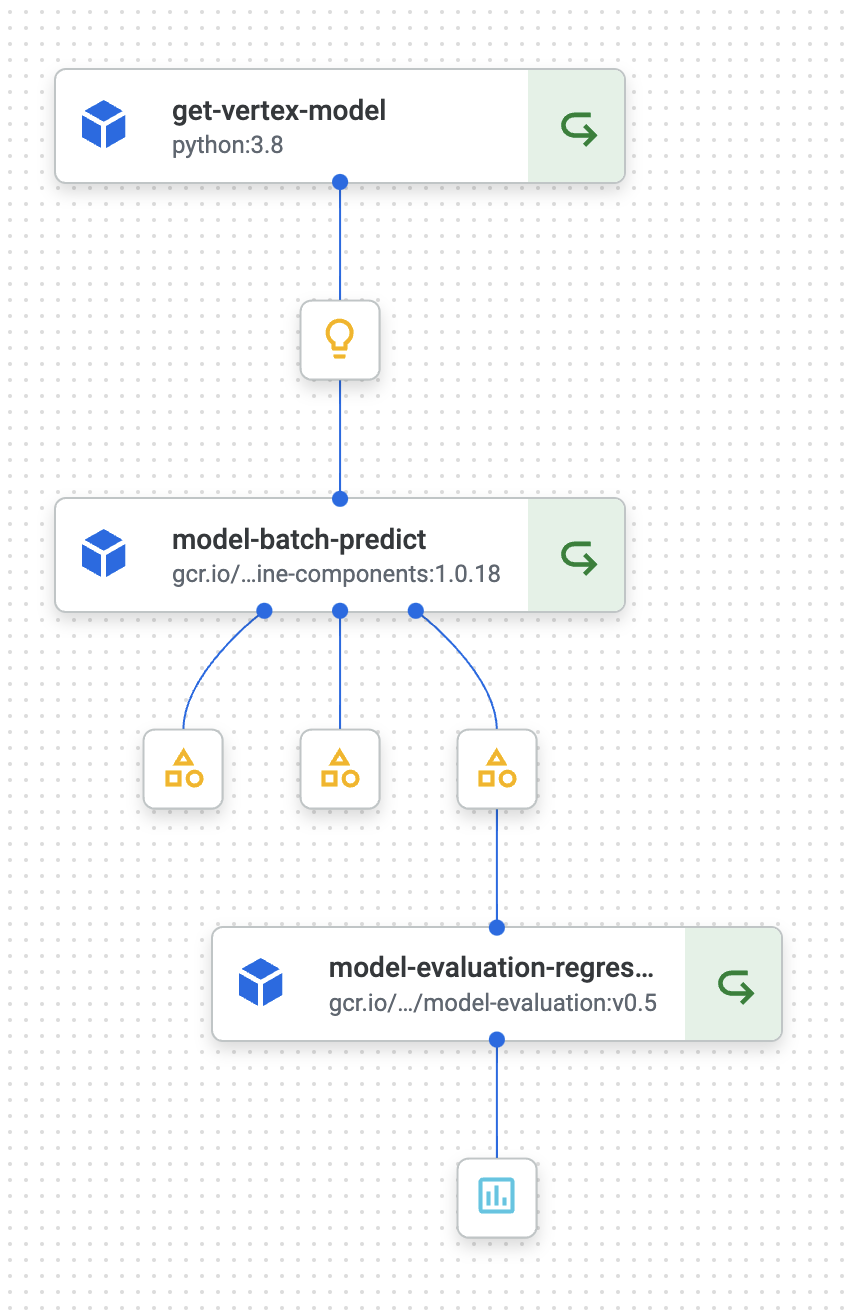

### Get the Model Evaluation Results

After the evalution pipeline is finished, run the below cell to print the evaluation metrics.

In [ ]:
# Iterate over the pipeline tasks
for task in job._gca_resource.job_detail.task_details:
    # Obtain the artifacts from the evaluation task
    if (("model-evaluation" in task.task_name) and
    ("model-evaluation-import" not in task.task_name) and
    (task.state == aiplatform_v1.types.PipelineTaskDetail.State.SUCCEEDED or task.state == aiplatform_v1.types.PipelineTaskDetail.State.SKIPPED)):
        evaluation_metrics = task.outputs.get('evaluation_metrics').artifacts[0] #['artifacts']
        evaluation_metrics_gcs_uri = evaluation_metrics.uri

print(evaluation_metrics)
print(evaluation_metrics_gcs_uri)

### Visualize the metrics



In [ ]:
import matplotlib.pyplot as plt
metrics = []
values = []
for i in evaluation_metrics.metadata.items():
    if i[0]=="meanAbsolutePercentageError": #we are not considering MAPE as it is infinite. MAPE is infinite if groud truth is 0 as in our case Age is 0 for some instances.
        continue
    metrics.append(i[0])
    values.append(i[1])
plt.figure(figsize=(10,5))
plt.bar(x=metrics,height=values)
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.show()

### Get the Feature Attributions

Run the below cell to get the feature attributions. 

In [ ]:
# Iterate over the pipeline tasks
for task in job._gca_resource.job_detail.task_details:
    # Obtain the artifacts from the feature-attribution task
    if ((task.task_name == "feature-attribution" ) and
        (task.state == aiplatform_v1.types.PipelineTaskDetail.State.SUCCEEDED or task.state == aiplatform_v1.types.PipelineTaskDetail.State.SKIPPED)):
        feat_attrs = task.outputs.get('feature_attributions').artifacts[0]
        feat_attrs_gcs_uri = feat_attrs.uri

print (feat_attrs)
print (feat_attrs_gcs_uri)

From the obtained Cloud Storage uri for the feature attributions, get the attribution values.

In [ ]:
# Load the results
attributions = !gsutil cat $feat_attrs_gcs_uri

# Print the results obtained
attributions = json.loads(attributions[0])
print (attributions)

### Visualize the Feature Attributions

Visualize the obtained attributions for each feature using a bar-chart.

In [ ]:
data = attributions["explanation"]["attributions"][0]["featureAttributions"]
features = []
attr_values = []
for key, value in data.items():
    features.append(key)
    attr_values.append(value)
    
plt.figure(figsize=(5,3))
plt.bar(x=features, height=attr_values)
plt.title("Feature Attributions")
plt.xticks(rotation=90)
plt.ylabel("Attribution value")
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

Set `delete_bucket` to **True** to create the Cloud Storage bucket created in this notebook.

In [ ]:
# Delete model resource
model.delete()

# Delete the dataset resource
dataset.delete()

# Delete the training job
train_job.delete()

# Delete the evaluation pipeline
job.delete()

# Delete Cloud Storage objects
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI